In [1]:
# Import packages
import os, sys, glob, re, math, pickle
import phate, scprep, magic, meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
import networkx as nx
import scvelo as scv
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import SpectralClustering, OPTICS, cluster_optics_dbscan, AgglomerativeClustering
from bbknn import bbknn
%matplotlib inline
%load_ext memory_profiler


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
# settings
plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=8)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1


In [4]:
# reproducibility
rs = np.random.seed(42)


In [5]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [6]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_human_ctype.h5ad' # for full, can maybe get away with ~300G
    %memit adata = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 11580.68 MiB, increment: 11276.34 MiB
loaded @230522.11:53:34
took 16.53-s to load data


In [ ]:
## Imputation by genotype
#k=45, t=3
print('Starting imputation for {}\n'.format('Ctrl'))
tic = time.time()

wt = adata[adata.obs['genotype']=='Ctrl', :]
wt.obs['value'] = 0
sc.pp.pca(wt)
sc.pp.neighbors(wt, n_pcs=45)


# MAGIC
G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

# MAGIC
magic_op=magic.MAGIC().fit(X=wt.X,graph=G) # running fit_transform produces wrong shape
wt.layers['imputed']=magic_op.transform(wt.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))


# save data objects
wt.write(os.path.join(pdfp,'230502_Ctrl_imp.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))




print('\n Starting imputation for {}\n'.format('SCA1'))
tic = time.time()

mut = adata[adata.obs['genotype']=='SCA1', :]
mut.obs['value'] = 0
sc.pp.pca(mut)
sc.pp.neighbors(mut, n_pcs=45)

# MAGIC
G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

# MAGIC
magic_op=magic.MAGIC().fit(X=mut.X,graph=G) # running fit_transform produces wrong shape
mut.layers['imputed']=magic_op.transform(mut.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))

# save data objects
mut.write(os.path.join(pdfp,'230502_SCA1_imp.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

Starting imputation for Ctrl



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:03:13)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:24)
Running MAGIC on 139780 cells and 34430 genes.
Using precomputed graph and diffusion operator...
Running MAGIC with `solver='exact'` on 34430-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...
Calculated imputation in 504.32 seconds.

  imputation in 12.32-min
saved @230502.16:25:09

 Starting imputation for SCA1



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:02:04)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:11)
Running MAGIC on 97776 cells and 34430 genes.
Using precomputed graph and diffusion operator...
Running MAGIC with `solver='exact'` on 34430-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...


In [ ]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_Ctrl_imp.h5ad' # for full, can maybe get away with ~300G
    %memit wt = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_SCA1_imp.h5ad' # for full, can maybe get away with ~300G
    %memit mut = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

In [ ]:
adata = wt.concatenate(mut, batch_key='concat')

In [ ]:
adata.obs.genotype.value_counts()

In [9]:
adata

AnnData object with n_obs × n_vars = 237556 × 34430
    obs: 'doublet_score', 'predicted_doublet', 'batch', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'n_counts', 'louvain', 'ctype2', 'sub1', 'sub2', 'sub3', 'sub4', 'value'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'batch_colors', 'ctype2_colors', 'dendrogram_sub1', 'dendrogram_sub3', 'genotype_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'sub1_colors', 'sub2_colors', 'sub3_colors', 'sub4_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
## Imputation for violin plot
#k=45, t=3
print('Starting imputation for {}\n'.format('Ctrl'))
tic = time.time()

adata.obs['value'] = 0
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs=45)


# MAGIC
G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
             precomputed='adjacency',
             use_pygsp=True)
G.knn_max = None

Starting imputation for Ctrl

computing PCA
    with n_comps=50
    finished (0:04:54)
computing neighbors
    using 'X_pca' with n_pcs = 45
    finished (0:00:38)


In [8]:
magic_genes = ['GABRA6','SLC17A7','EOMES','ATP2A3','CALB1','CA8',
           'PPP1R17','SLC1A6','GAD1','GAD2','NTN1','MEGF10','ALDH1L1','AQP4',
           'GDF10','HOPX','OLIG1','OLIG2','PDGFRA','HAPLN2','MAG','MOG',
           'OPALIN','C1QB','CX3CR1','DOCK2','P2RY12','FLT1',
           'RGS5','DCN','LUM','KDR']

adata=adata[:,magic_genes]
adata

View of AnnData object with n_obs × n_vars = 237556 × 32
    obs: 'doublet_score', 'predicted_doublet', 'batch', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'n_counts', 'louvain', 'ctype2', 'sub1', 'sub2', 'sub3', 'sub4', 'value'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'batch_colors', 'ctype2_colors', 'dendrogram_sub1', 'dendrogram_sub3', 'genotype_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'sub1_colors', 'sub2_colors', 'sub3_colors', 'sub4_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
magic_op=magic.MAGIC().fit(X=adata.X,graph=G) # running fit_transform produces wrong shape
adata.layers['imputed']=magic_op.transform(adata.X,genes='all_genes')

print('\n  imputation in {:.2f}-min'.format((time.time() - tic)/60))

Running MAGIC on 237556 cells and 32 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...
Calculated imputation in 0.58 seconds.

  imputation in 5.83-min


In [10]:
markers = {
    'Granule cell':['GABRA6','SLC17A7'],
    'Unipolar brush cell':['EOMES'],
    'Purkinje cell':['ATP2A3','CALB1','CA8','PPP1R17','SLC1A6'],
    'Inhibitory interneuron':['GAD1','GAD2','NTN1','MEGF10'],
    'Astrocyte':['ALDH1L1','AQP4'],
    'Bergmann glia':['GDF10','HOPX'],
    'OPC':['OLIG1','OLIG2','PDGFRA'],
    'OL':['HAPLN2','MAG','MOG','OPALIN'],
    'Microglia':['C1QB','CX3CR1','DOCK2','P2RY12'],
    'Pericytes':['FLT1','RGS5'],
    'Endothelial cell':['DCN','LUM','KDR']
}

In [11]:
## swapping color manually - use for violin after imputation

cmap_sub4={'GC': '#F9EBAE',
            'UBC': '#1C67EE',
            'PC': '#AC5861',
            'MLI1': '#F9AEAE',
            'MLI2': '#AEB7F9',
            'GoC': '#88BB92',
            'AS': '#FAC18A',
            'BG': '#BA61BA',
            'OPC': '#75A3B7',
            'OL': '#F1815F',
            'MG': '#46A928',
            'PER': '#2D284B',
            'END': '#EE5264'}

adata.uns['sub4_colors']=np.array(list(cmap_sub4.values()),dtype=object)
adata.obs['sub4'].cat.reorder_categories(new_categories=list(cmap_sub4.keys()),
                                         inplace=True,ordered=True)

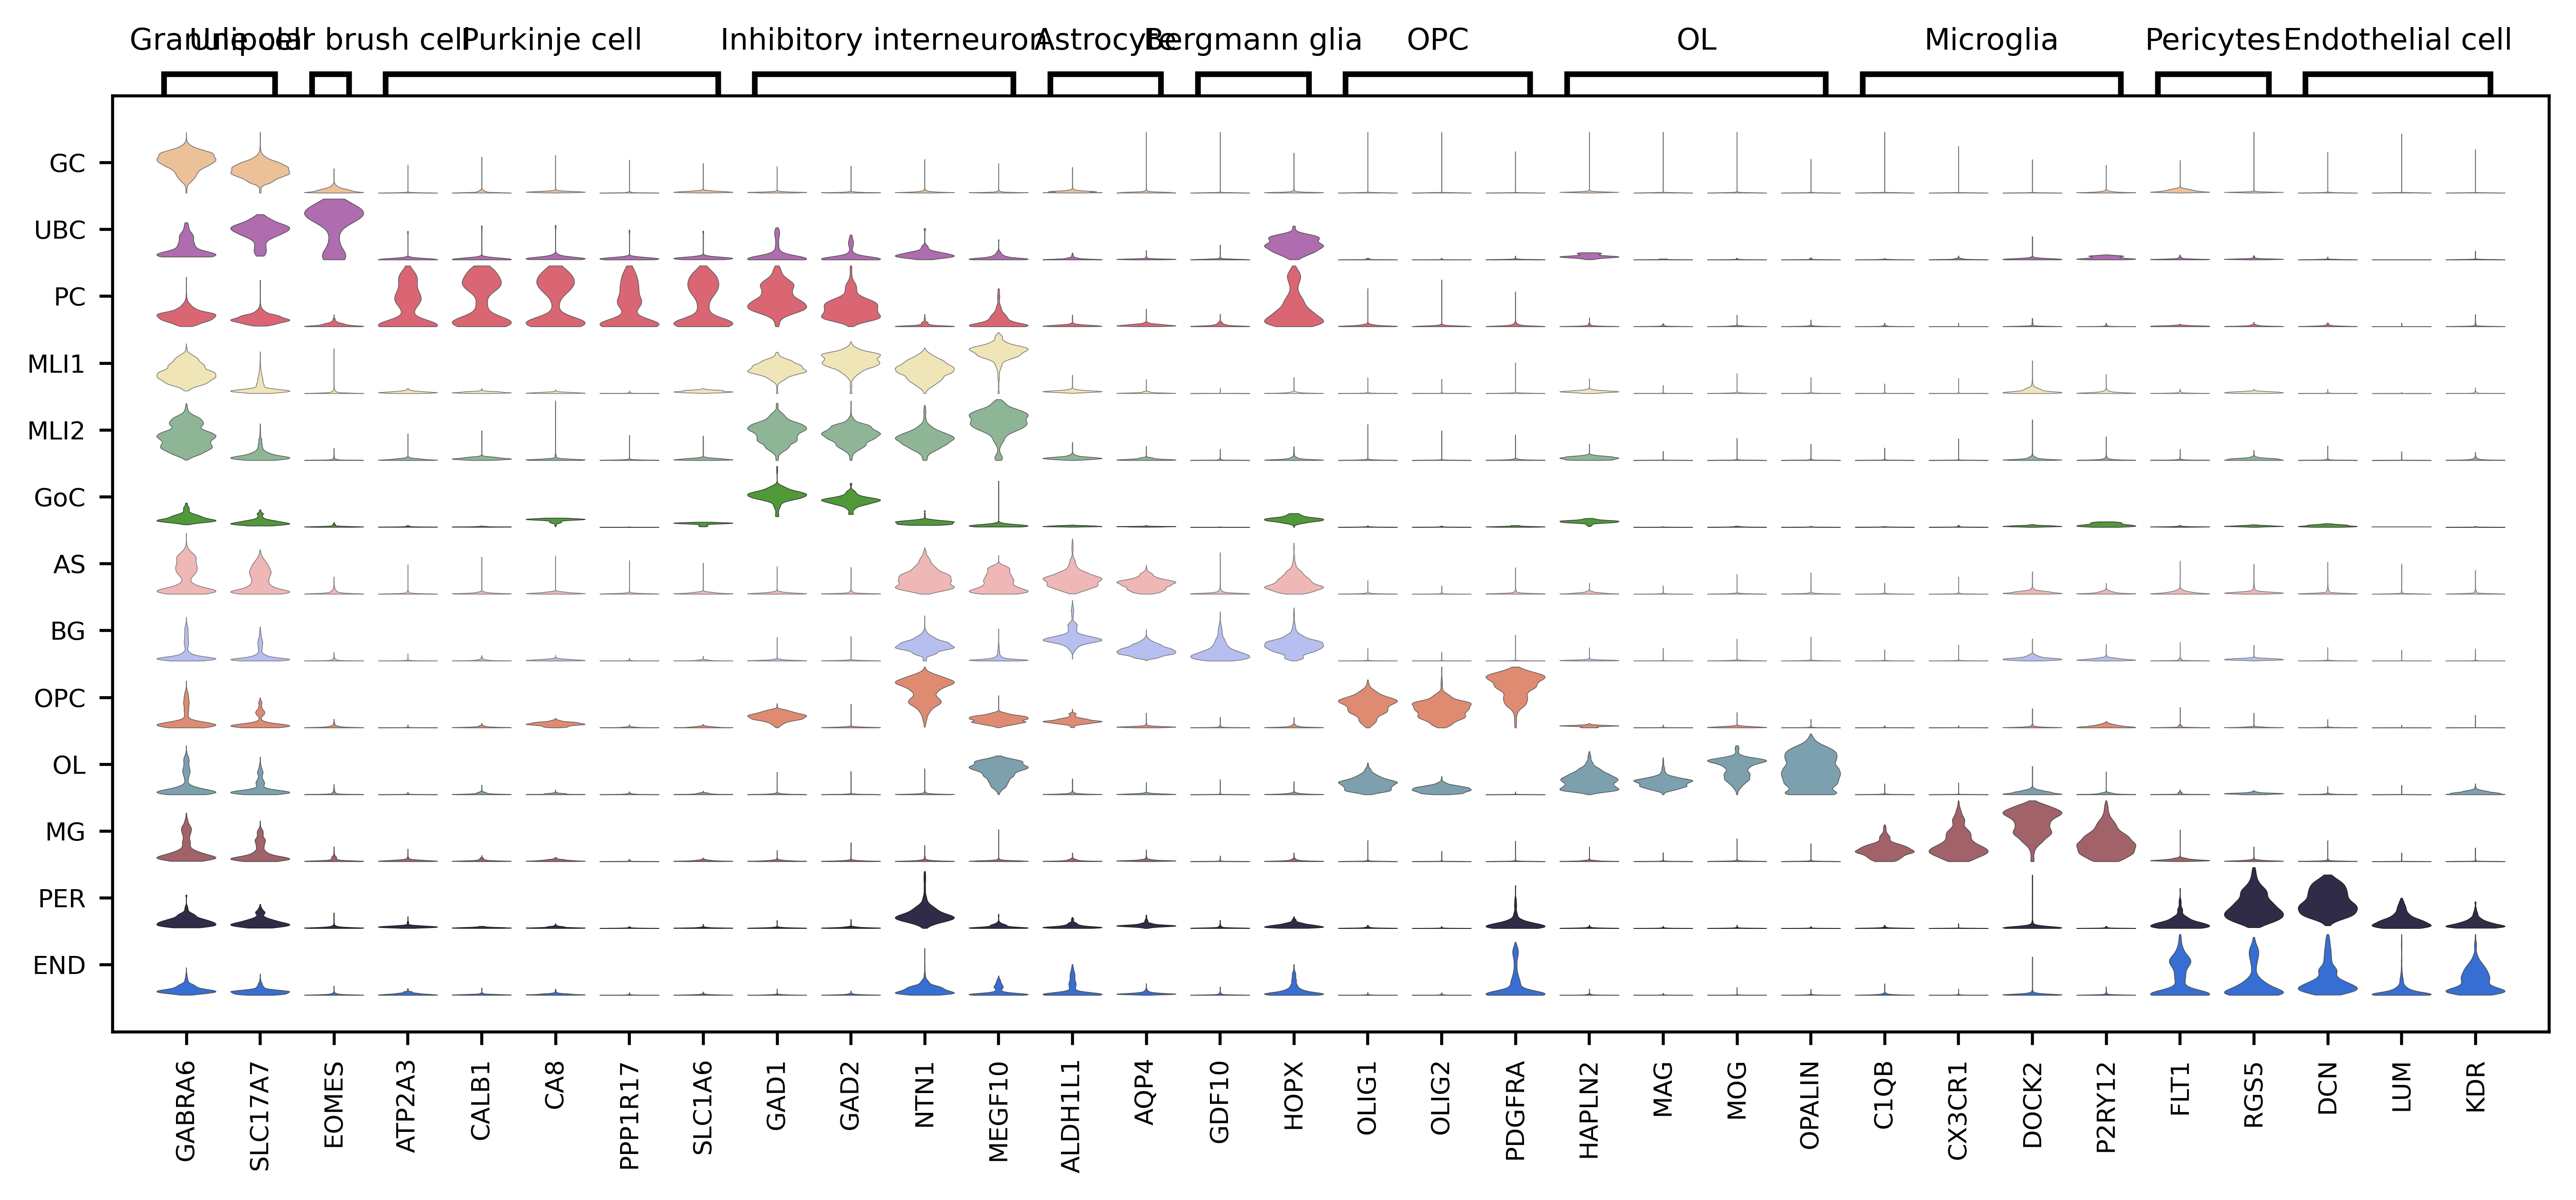

In [12]:
sc.pl.stacked_violin(adata, markers, groupby='sub4', 
                     use_raw = False, var_group_rotation=0, 
                     layer = 'imputed', standard_scale='var',
                    row_palette=[cmap_sub4[i] for i in sorted(cmap_sub4.keys())],
                    save = '230522_human_violin')

In [48]:
# save data objects
bdata.write(os.path.join(pdfp,'230515_human_imp_violin_48genes.h5ad'))
print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))

saved @230515.14:43:07
